In [1029]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [1030]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [1031]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [1032]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [1033]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [1034]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'       ])

y_test = nba_test.away_cover

In [1035]:

X_test.shape

(150, 148)

In [1036]:
X_train.shape

(711, 148)

### Interaction Terms

At one point in the modeling process I hoped to get better results by including some interactions in the model.  They did not appear significant and added noise so they were removed, but I left the code in case I wanted to reinsert them later. 

In [1037]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


### Scale and Transform the data

I use standard scaler scale the data and then do a principal components analysis to transform the data.  I do not care about inference in this case only prediction and there is a good deal of correlation between variables. So I decided to transform the data to reduce the number and get orthoginal features without losing much information.  I retain 99% of the variance.

In [1038]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [1039]:
from sklearn.decomposition import PCA

In [1040]:
pc = PCA(n_components=75)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [1041]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.11694139 0.10466322 0.06263363 0.04348807 0.04020162 0.03739641
 0.03465436 0.03171007 0.03088486 0.02746436 0.0268335  0.02449559
 0.02349233 0.01981358 0.0187899  0.01781639 0.01615334 0.01557077
 0.01526551 0.01447885 0.01406536 0.01263087 0.01230269 0.01185432
 0.01148084 0.01019796 0.01010359 0.00978173 0.00931831 0.00867519
 0.00824706 0.00784966 0.00771266 0.00722275 0.00688001 0.00657454
 0.00636737 0.00601614 0.00578821 0.00543573 0.00496192 0.00474887
 0.00467484 0.0045144  0.00415594 0.00392611 0.00377081 0.0036287
 0.00338606 0.00335798 0.00319686 0.00307144 0.00295852 0.00272001
 0.00264951 0.00254457 0.00240447 0.0023217  0.00207763 0.00197976
 0.0019091  0.00185138 0.0018229  0.00167725 0.00158737 0.00148908
 0.00139441 0.00136833 0.00132082 0.00125973 0.00115397 0.00110103
 0.00104157 0.00099801 0.0009725 ]
Cumulative explained variance:  [0.11694139 0.22160461 0.28423824 0.32772631 0.36792792 0.40532433
 0.43997869 0.47168876 0.502573

### Logistic Regression

The first model I tested out was the logistic regression on good thing about the NBA data is that much of the data seemed to be normally distributed and my transformed features are uncorrelated so I thought

In [1042]:
lr = LogisticRegressionCV(Cs = [1000],
                         max_iter=1000,
                         penalty = 'l1',
                         tol = .00001,
                         solver ='saga' )


lr.fit(X_train_pc, y_train)
print(lr.score(X_train_pc, y_train))


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6469760900140648


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [1043]:
lr.score(X_test_pc, y_test)

0.56

In [1044]:
y_hat_lr   = lr.predict(X_train_pc)
y_hat_lrp  = lr.predict_proba(X_train_pc)
y_hat_lrt  = lr.predict(X_test_pc)
y_hat_lrtp = lr.predict_proba(X_test_pc)

In [1045]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61       333
           1       0.66      0.69      0.68       378

   micro avg       0.65      0.65      0.65       711
   macro avg       0.65      0.64      0.64       711
weighted avg       0.65      0.65      0.65       711



In [1046]:
print(classification_report(y_test, y_hat_lrt))

              precision    recall  f1-score   support

           0       0.54      0.66      0.59        73
           1       0.59      0.47      0.52        77

   micro avg       0.56      0.56      0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.57      0.56      0.56       150



In [1047]:
confusion_matrix( y_train, y_hat_lr)

array([[199, 134],
       [117, 261]])

In [1048]:
confusion_matrix( y_test, y_hat_lrt)

array([[48, 25],
       [41, 36]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [1049]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.05, .15, .1]
    }

In [1050]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5690647664978252
{'C': 0.1, 'kernel': 'linear'}


In [1051]:
gs.score(X_test_pc, y_test)

0.5967741935483871

In [1052]:
#predict categories and  probabilities for svc model

y_hat_svc   = gs.predict(X_train_pc)
y_hat_svcp  = gs.predict_proba(X_train_pc)
y_hat_svct  = gs.predict(X_test_pc)
y_hat_svctp = gs.predict_proba(X_test_pc)

In [1053]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       333
           1       0.67      0.72      0.69       378

   micro avg       0.66      0.66      0.66       711
   macro avg       0.66      0.66      0.66       711
weighted avg       0.66      0.66      0.66       711



In [1054]:
print(classification_report(y_test, y_hat_svct))

              precision    recall  f1-score   support

           0       0.55      0.66      0.60        73
           1       0.60      0.48      0.53        77

   micro avg       0.57      0.57      0.57       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.57      0.57      0.56       150



In [1055]:
confusion_matrix( y_train, y_hat_svc)

array([[196, 137],
       [105, 273]])

In [1056]:
confusion_matrix( y_test, y_hat_svct)

array([[48, 25],
       [40, 37]])

### Neural Network

I also wanted to try fitting a neural network.  I do not care about the inference implications, but I found that the neural network had to much variance depending on starting weights so I decided not to use it in predictions.  

In [1057]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

In [1058]:
model = Sequential()
model.add(Dense(60, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.85))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [1059]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =30, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/30
711/711 [==============================] - 1s 1ms/step - loss: 1.9175 - acc: 0.5288 - val_loss: 1.6052 - val_acc: 0.4200
Epoch 2/30
711/711 [==============================] - 0s 18us/step - loss: 1.8523 - acc: 0.5359 - val_loss: 1.5626 - val_acc: 0.4267
Epoch 3/30
711/711 [==============================] - 0s 18us/step - loss: 1.9105 - acc: 0.5246 - val_loss: 1.5208 - val_acc: 0.4333
Epoch 4/30
711/711 [==============================] - 0s 22us/step - loss: 1.8438 - acc: 0.5232 - val_loss: 1.4808 - val_acc: 0.4267
Epoch 5/30
711/711 [==============================] - 0s 21us/step - loss: 1.7601 - acc: 0.5260 - val_loss: 1.4473 - val_acc: 0.4267
Epoch 6/30
711/711 [==============================] - 0s 20us/step - loss: 1.7733 - acc: 0.5007 - val_loss: 1.4158 - val_acc: 0.4467
Epoch 7/30
711/711 [==============================] - 0s 19us/step - loss: 1.5830 - acc: 0.5387 - val_loss: 1.3895 - val_acc: 0.4667
Epoch 8/30
711/711 [====

In [1060]:
#returns a probability

y_hat_nnp = model.predict(X_train_pc)
y_hat_nntp = model.predict(X_test_pc)


In [1061]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [200],
             'max_depth'         : [3],
             'min_samples_split' : [120],
             'min_samples_leaf'  : [10] }

gs1 = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv =5)
gs1.fit(X_train_pc, y_train)
print(gs1.best_score_)
print(gs1.best_params_)



0.5357732351484347
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 120, 'n_estimators': 200}


In [1062]:
gs1.score(X_test_pc, y_test)

0.5546875

In [1063]:
y_hat_rf   = gs1.predict(X_train_pc)
y_hat_rfp  = gs1.predict_proba(X_train_pc)
y_hat_rft  = gs1.predict(X_test_pc)
y_hat_rftp = gs1.predict_proba(X_test_pc)

In [1064]:
print(classification_report(y_train, y_hat_rf))

              precision    recall  f1-score   support

           0       0.96      0.39      0.55       333
           1       0.65      0.98      0.78       378

   micro avg       0.71      0.71      0.71       711
   macro avg       0.80      0.69      0.67       711
weighted avg       0.79      0.71      0.67       711



In [1065]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.73      0.22      0.34        73
           1       0.55      0.92      0.69        77

   micro avg       0.58      0.58      0.58       150
   macro avg       0.64      0.57      0.51       150
weighted avg       0.64      0.58      0.52       150



In [1066]:
confusion_matrix( y_train, y_hat_rf)

array([[130, 203],
       [  6, 372]])

In [1067]:
confusion_matrix( y_test, y_hat_rft)

array([[16, 57],
       [ 6, 71]])

In [1068]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#SVC

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

#Logistic
nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]



In [1069]:
#Random Forest
nba_test.loc[:, 'actual_y'] = y_test
nba_test.loc[:, 'predicted_label_rf'] = y_hat_rft
nba_test.loc[:, 'predicted_proba_rfp'] = y_hat_rftp[:, 1]

#SVC

nba_test.loc[:, 'predicted_label_svc'] = y_hat_svct
nba_test.loc[:, 'predicted_proba_svcp'] = y_hat_svctp[:,1]

#Logistic
nba_test.loc[:, 'predicted_label_lr'] = y_hat_lrt
nba_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrtp[:, 1]








In [1070]:
print(nba_test.groupby(['predicted_label_svc'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_svc'])['home_payout'].sum())

predicted_label_svc
0   -9.640
1    8.633
Name: away_payout, dtype: float64
predicted_label_svc
0     1.814
1   -14.275
Name: home_payout, dtype: float64


In [1071]:
print(nba_test.groupby(['predicted_label_lr'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_lr'])['home_payout'].sum())

predicted_label_lr
0   -9.731
1    8.724
Name: away_payout, dtype: float64
predicted_label_lr
0     1.723
1   -14.184
Name: home_payout, dtype: float64


In [1072]:
print(nba_test.groupby(['predicted_label_rf'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_rf'])['home_payout'].sum())

predicted_label_rf
0   -10.546
1     9.539
Name: away_payout, dtype: float64
predicted_label_rf
0     8.544
1   -21.005
Name: home_payout, dtype: float64


In [1073]:
from sklearn.metrics import roc_curve, auc

In [1074]:
fpr, tpr, _ = roc_curve(y_test, nba_test['predicted_proba_lrp'])
roc_auc = auc(fpr, tpr)

In [1075]:
fpr1, tpr1, _ = roc_curve(y_test, nba_test['predicted_proba_svcp'])
roc_auc1 = auc(fpr1, tpr1)

In [1076]:
fpr2, tpr2, _ = roc_curve(y_test, nba_test['predicted_proba_rfp'])
roc_auc2 = auc(fpr2, tpr2)

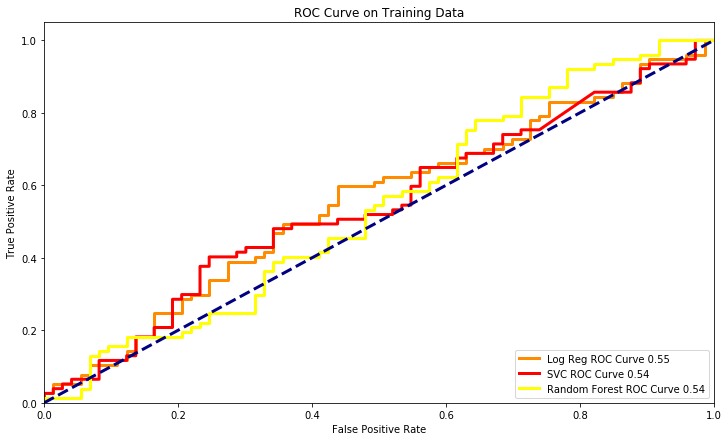

In [1077]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "SVC ROC Curve %.2f" % roc_auc1)
plt.plot(fpr2, tpr2, lw = line_width, color="yellow", 
         label = "Random Forest ROC Curve %.2f" % roc_auc2)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [1078]:
for prob in range(42, 55, 1):
    proba = prob/100
    
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
        lambda p: 1 if p > proba else 0)
    


    
    print('Test Logistic Regression :' + str(proba))

    print ("Return of Away Games: ", nba_test.groupby(
        "predicted_label_lr").away_payout.sum())
    print ("Return of Home Games: ", nba_test.groupby(
        "predicted_label_lr").home_payout.sum())
    
    print (" ")
   

    
  

Test Logistic Regression :0.42
Return of Away Games:  predicted_label_lr
0   -8.730
1    7.723
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     2.724
1   -15.185
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.43
Return of Away Games:  predicted_label_lr
0   -9.821
1    8.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     3.542
1   -16.003
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.44
Return of Away Games:  predicted_label_lr
0   -11.821
1    10.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     5.360
1   -17.821
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.45
Return of Away Games:  predicted_label_lr
0   -10.912
1     9.905
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     4.360
1   -16.821
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.46
Return of Away Games:  predicted_label_lr

### Threshold Analysis

For the Logisitic Regession Analysis .44 seems to consistently rank a the best threshold.  Therefore, I change the classification to .44.  W

I conducted a Threshold Analysis to determine if I should set the probability Threshold at a value other than .5.  The Roc curve does not show any enormous jumps in precision.  Running the model a number of times.  The maximum precision is usually between .48 and .52 but is not consistent across models. 

Therefore, I am leaving the break point at .5 since that point consistently show a profitable break..

In [1080]:
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
    lambda p: 1 if p > .44 else 0)
    
    nba_test.loc[:, 'predicted_label_svc']= nba_test.predicted_proba_svcp.map(
    lambda p: 1 if p > .50 else 0)

In [1081]:
nba_test['vote']= (nba_test.predicted_label_svc + 
                   nba_test.predicted_label_lr)

print(nba_test.vote.value_counts(normalize = True))
print(nba_test.groupby(['vote'])['away_payout'].sum())
print(nba_test.groupby(['vote'])['home_payout'].sum())

2    0.520000
0    0.253333
1    0.226667
Name: vote, dtype: float64
vote
0    -1.729
1   -10.092
2    10.814
Name: away_payout, dtype: float64
vote
0    -1.729
1     7.089
2   -17.821
Name: home_payout, dtype: float64


In [1082]:
#Combined 
nba_test['vote_with_rf'] = (nba_test.predicted_label_svc + 
                            nba_test.predicted_label_lr +
                            nba_test.predicted_label_rf)

In [1083]:
nba_test.vote_with_rf.value_counts(normalize = True)

3    0.506667
2    0.200000
1    0.200000
0    0.093333
Name: vote_with_rf, dtype: float64

In [1084]:
nba_test.groupby(['vote_with_rf'])['away_payout'].sum()

vote_with_rf
0    -8.273
1     4.362
2    -8.001
3    10.905
Name: away_payout, dtype: float64

In [1085]:
nba_test.groupby(['vote_with_rf'])['home_payout'].sum()

vote_with_rf
0     6.999
1    -7.092
2     5.362
3   -17.730
Name: home_payout, dtype: float64

In [1086]:
print(nba_test.predicted_label_svc.head(10))
nba_test.groupby(['predicted_label_svc'])['predicted_proba_svcp'].mean()
    

10206    1
10207    1
10208    1
10242    1
10243    0
10244    1
10245    0
10246    0
10247    0
10248    0
Name: predicted_label_svc, dtype: int64


predicted_label_svc
0    0.487372
1    0.532259
Name: predicted_proba_svcp, dtype: float64

### Results 

I added a section with the Random Forest Estimator included in the ensemble prediction.  It generally predicts better than the two model ensemble, but includes more variance.  The two model ensemble classifier is consistently positive with both models agreeing betting the away team and if not betting the home team. 

If you include the Random Forest.  The best predictions are betting the away team if all three models predict the away team else bet the home team. 

,dataset,date,teams,home_starter5,crew_referees,spread,total,moneyline,away_team,away_pace,...,in_conference_game,actual_y,predicted_label_rf,predicted_proba_rfp,predicted_label_svc,predicted_proba_svcp,predicted_label_lr,predicted_proba_lrp,vote,vote_with_rf
10206,2017 Playoffs,2017-04-16,Washington,John Wall,Zach Zarba,-5.0,210.0,-240.0,Atlanta,100.2,...,1,0,0,0.494670,1,0.508624,0,0.397912,1,1
10207,2017 Playoffs,2017-04-19,Washington,John Wall,David Guthrie,-5.5,212.0,-250.0,Atlanta,98.6,...,1,0,1,0.515615,1,0.514083,0,0.384416,1,2
10208,2017 Playoffs,2017-04-26,Washington,John Wall,James Williams,-5.5,212.0,-280.0,Atlanta,93.5,...,1,1,1,0.515357,1,0.553941,1,0.667802,2,3
10242,2017 Playoffs,2017-04-21,Chicago,Jerian Grant,Brian Forte,-1.5,207.0,115.0,Boston,92.0,...,1,1,1,0.528463,1,0.546206,1,0.596870,2,3
10243,2017 Playoffs,2017-04-23,Chicago,Jerian Grant,Eric Lewis,2.0,204.0,100.0,Boston,90.0,...,1,1,1,0.521467,0,0.500000,0,0.364219,0,1
10244,2017 Playoffs,2017-04-28,Chicago,Isaiah Canaan,James Williams,0.0,204.0,135.0,Boston,90.1,...,1,1,1,0.524604,1,0.518917,1,0.471110,2,3
10245,2017 Playoffs,2017-05-04,Washington,John Wall,Tony Brown,-5.0,219.5,-250.0,Boston,96.4,...,1,0,0,0.464201,0,0.449682,0,0.092167,0,0
10246,2017 Playoffs,2017-05-07,Washington,John Wall,Ron Garretson,-4.5,215.0,-200.0,Boston,99.1,...,1,0,0,0.472905,0,0.479131,0,0.173289,0,0
10247,2017 Playoffs,2017-05-12,Washington,John Wall,John Goble,-5.5,216.5,-215.0,Boston,90.6,...,1,1,0,0.494745,0,0.472497,0,0.194460,0,0
10248,2017 Playoffs,2017-05-21,Cleveland,Kyrie Irving,David Guthrie,-5.5,220.0,-4000.0,Boston,90.4,...,1,1,1,0.514837,0,0.484631,0,0.305897,0,1
